In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.autograd import grad
from torch import nn, optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms

In [2]:
import sys
sys.path.append("./../")

# from modules.dtr_gan.generator import Generator
# from modules.dtr_gan.discriminator import Discriminator
from modules.vqvae.model import VQVAE

from modules.common_blocks import ResidualStack
from modules.dtr_gan.blocks import PositionalEmbedding, MLP
from train_utils.dvae_utils import TemperatureAnnealer

In [3]:
def show(img, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [4]:
!pwd

/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/notebooks


In [5]:
class Config:
    DEVICE                      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    noise_dim                   = 32
    hidden_width                = 7
    hidden_height               = 7
    num_blocks                  = 10
    dropout_prob                = 0.1
    
    img_channels                = 1
    vocab_size                  = 32
    embedding_dim               = 128
    commitment_cost             = 0.25
    decay                       = 0.99
    num_x2downsamples           = 2
    num_resids_downsample       = 2
    num_resids_bottleneck       = 4
    hidden_dim                  = 256

    vqvae_path                  = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/vqvae_S_mnist/"
    vqvae_model_name            = "vqvae_S_mnist"
    data_path                   = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"
    
    NUM_EPOCHS                  = 100
    BATCH_SIZE                  = 512
    LR                          = 0.01
    LR_gamma                    = 0.1
    step_LR_milestones          = [5, 10]


CONFIG = Config()

In [6]:
data_transforms = torch_transforms.Compose([
    torch_transforms.RandomRotation(10),
    torch_transforms.ToTensor()
])

trainset = datasets.MNIST(
    CONFIG.data_path,
    train=True,
    download=False,
    transform=data_transforms)

train_loader = DataLoader(
    trainset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True)

# x, _ = next(iter(train_loader))
# img_grid = make_grid(x[:64, :, :, :].detach().cpu())
# show(img_grid)

In [7]:
len(trainset) / CONFIG.BATCH_SIZE

117.1875

In [8]:
class Generator(nn.Module):
    def __init__(self,
                 noise_dim,
                 hidden_width,
                 hidden_height,
                 embedding_dim,
                 num_blocks,
                 dropout_prob):
        super(Generator, self).__init__()

        self.hidden_width = hidden_width
        self.hidden_height = hidden_height
        self.embedding_dim = embedding_dim
        bias = False

        self.noise_converter = nn.Sequential(
            nn.ConvTranspose2d(in_channels=noise_dim, out_channels=embedding_dim, 
                               kernel_size=3, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=embedding_dim, out_channels=embedding_dim, 
                               kernel_size=3, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=embedding_dim, out_channels=embedding_dim, 
                               kernel_size=3, stride=1, padding=0, bias=bias)
        )

        self.residual = ResidualStack(
            in_channels=embedding_dim,
            out_channels=embedding_dim,
            num_residual_layers=num_blocks,
            bias=bias,
            use_bn=True,
            final_relu=False)

    def forward(self, noise, tau=1/16, hard=False):
        x = self.noise_converter(noise)
        z_logits = self.residual(x)
        #z = self.quantize(z_logits, tau=tau, hard=hard)
        #z = F.softmax(z_logits, dim=1)
        return z_logits

    def quantize(self, z_logits, tau=1/16, hard=False):
        return F.gumbel_softmax(z_logits, tau=tau, hard=hard, dim=1)


In [9]:
class Discriminator(nn.Module):
    def __init__(self,
                 embedding_dim,
                 num_blocks):
        super(Discriminator, self).__init__()
        
        self.resid = ResidualStack(
            in_channels=embedding_dim, 
            out_channels=embedding_dim, 
            num_residual_layers=num_blocks, 
            bias=True, 
            use_bn=True, 
            final_relu=False)
        
        channels_dims = [
            embedding_dim // 2,
            embedding_dim // 4,
        ]
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=embedding_dim,
                      out_channels=channels_dims[0],
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=channels_dims[0]),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels_dims[0], 
                      out_channels=channels_dims[1], 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=channels_dims[1]),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels_dims[1], 
                      out_channels=channels_dims[1], 
                      kernel_size=3, padding=0),
            nn.ReLU(),
        )
        
        self.fc = nn.Linear(in_features=channels_dims[1], out_features=1)

    def forward(self, x):
        x = self.resid(x)
        x = self.conv(x)
        x = self.fc(x.squeeze())
        return torch.sigmoid(x.squeeze())

In [13]:
vqvae = VQVAE(
    img_channels=CONFIG.img_channels,
    num_embeddings=CONFIG.vocab_size,
    embedding_dim=CONFIG.embedding_dim,
    commitment_cost=CONFIG.commitment_cost,
    decay=CONFIG.decay,
    num_x2downsamples=CONFIG.num_x2downsamples,
    num_resid_downsample_layers=CONFIG.num_resids_downsample,
    num_resid_bottleneck_layers=CONFIG.num_resids_bottleneck,
    bias=True,
    use_batch_norm=True,
    use_conv1x1=False)

G = Generator(
    noise_dim=CONFIG.noise_dim,
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.embedding_dim,
    num_blocks=CONFIG.num_blocks,
    dropout_prob=CONFIG.dropout_prob)

D = Discriminator(
    embedding_dim=CONFIG.embedding_dim,
    num_blocks=CONFIG.num_blocks)

optimizer_G = optim.Adam(G.parameters(), lr=CONFIG.LR)
optimizer_D = optim.Adam(D.parameters(), lr=CONFIG.LR)

lr_scheduler_G = MultiStepLR(optimizer_G, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)
lr_scheduler_D = MultiStepLR(optimizer_D, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)


In [14]:
vqvae.eval()
G.train()
D.train()

vqvae.to(CONFIG.DEVICE)
G.to(CONFIG.DEVICE)
D.to(CONFIG.DEVICE)

vqvae.load_model(
    root_path=CONFIG.vqvae_path,
    model_name=CONFIG.vqvae_model_name, 
    map_location=CONFIG.DEVICE)

pass

Device in use: cuda
Epoch: 0 Iter: 55 GLoss: 13.76135 DLoss: 0.0023 Avg_D_real 0.99542 Avg_D_fake 1e-05
Epoch: 0 Iter: 110 GLoss: 13.39056 DLoss: 0.49186 Avg_D_real 0.8754 Avg_D_fake 0.56499
Epoch: 1 Iter: 165 GLoss: 12.04587 DLoss: 0.00205 Avg_D_real 0.99617 Avg_D_fake 0.00025
Epoch: 1 Iter: 220 GLoss: 5.93765 DLoss: 0.03214 Avg_D_real 0.96414 Avg_D_fake 0.02513
Epoch: 2 Iter: 275 GLoss: 5.34659 DLoss: 0.13021 Avg_D_real 0.81222 Avg_D_fake 0.04114
Epoch: 2 Iter: 330 GLoss: 6.01067 DLoss: 0.04446 Avg_D_real 0.94357 Avg_D_fake 0.02981
Epoch: 3 Iter: 385 GLoss: 5.84509 DLoss: 0.04161 Avg_D_real 0.95382 Avg_D_fake 0.02962
Epoch: 3 Iter: 440 GLoss: 5.54082 DLoss: 0.00397 Avg_D_real 0.99904 Avg_D_fake 0.00696
Epoch: 4 Iter: 495 GLoss: 6.95911 DLoss: 0.09059 Avg_D_real 0.96421 Avg_D_fake 0.13334
Epoch: 4 Iter: 550 GLoss: 6.70781 DLoss: 0.04985 Avg_D_real 0.99617 Avg_D_fake 0.09134
====== Epoch 4 ======


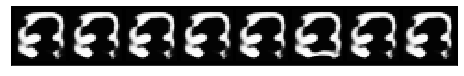

Epoch: 5 Iter: 605 GLoss: 8.94348 DLoss: 0.26668 Avg_D_real 0.9997 Avg_D_fake 0.41278
Epoch: 5 Iter: 660 GLoss: 8.03289 DLoss: 0.00056 Avg_D_real 0.99945 Avg_D_fake 0.00055
Epoch: 6 Iter: 715 GLoss: 6.35839 DLoss: 0.17901 Avg_D_real 0.77609 Avg_D_fake 0.07663
Epoch: 6 Iter: 770 GLoss: 2.70797 DLoss: 0.00728 Avg_D_real 0.99901 Avg_D_fake 0.01346
Epoch: 6 Iter: 825 GLoss: 5.26176 DLoss: 0.02385 Avg_D_real 0.97406 Avg_D_fake 0.01606
Epoch: 7 Iter: 880 GLoss: 5.38645 DLoss: 0.0158 Avg_D_real 0.97788 Avg_D_fake 0.00766
Epoch: 7 Iter: 935 GLoss: 4.43081 DLoss: 0.01475 Avg_D_real 0.99693 Avg_D_fake 0.02606
Epoch: 8 Iter: 990 GLoss: 5.4952 DLoss: 0.00408 Avg_D_real 0.99877 Avg_D_fake 0.0069
Epoch: 8 Iter: 1045 GLoss: 12.28463 DLoss: 0.00228 Avg_D_real 0.99551 Avg_D_fake 1e-05
Epoch: 9 Iter: 1100 GLoss: 6.16238 DLoss: 0.01255 Avg_D_real 0.9927 Avg_D_fake 0.01757
Epoch: 9 Iter: 1155 GLoss: 8.1792 DLoss: 0.0144 Avg_D_real 0.98391 Avg_D_fake 0.01092
====== Epoch 9 ======


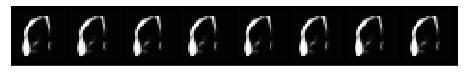

Epoch: 10 Iter: 1210 GLoss: 4.13143 DLoss: 10.53772 Avg_D_real 0.0 Avg_D_fake 0.00018
Epoch: 10 Iter: 1265 GLoss: 5.1535 DLoss: 0.02982 Avg_D_real 0.98634 Avg_D_fake 0.04324
Epoch: 11 Iter: 1320 GLoss: 55.1535 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 11 Iter: 1375 GLoss: 53.11492 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 12 Iter: 1430 GLoss: 53.11275 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 12 Iter: 1485 GLoss: 53.11082 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 13 Iter: 1540 GLoss: 53.10716 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 13 Iter: 1595 GLoss: 53.10217 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 13 Iter: 1650 GLoss: 53.10713 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 14 Iter: 1705 GLoss: 53.10434 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 14 Iter: 1760 GLoss: 53.10699 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
====== Epoch 14 ======


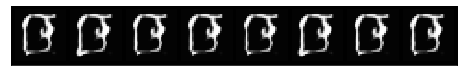

Epoch: 15 Iter: 1815 GLoss: 53.10858 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 15 Iter: 1870 GLoss: 53.09949 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 16 Iter: 1925 GLoss: 53.10013 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 16 Iter: 1980 GLoss: 53.10413 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 17 Iter: 2035 GLoss: 53.11083 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 17 Iter: 2090 GLoss: 53.11591 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 18 Iter: 2145 GLoss: 53.11266 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 18 Iter: 2200 GLoss: 53.10894 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 19 Iter: 2255 GLoss: 53.10271 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 19 Iter: 2310 GLoss: 53.10984 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
====== Epoch 19 ======


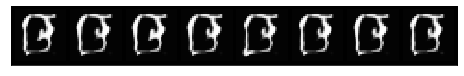

Epoch: 20 Iter: 2365 GLoss: 53.10508 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 20 Iter: 2420 GLoss: 53.11051 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 20 Iter: 2475 GLoss: 53.11462 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 21 Iter: 2530 GLoss: 53.10752 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 21 Iter: 2585 GLoss: 53.11054 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 22 Iter: 2640 GLoss: 53.10395 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 22 Iter: 2695 GLoss: 53.10228 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 23 Iter: 2750 GLoss: 53.10253 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 23 Iter: 2805 GLoss: 53.11342 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 24 Iter: 2860 GLoss: 53.11488 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 24 Iter: 2915 GLoss: 53.10612 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
====== Epoch 24 ======


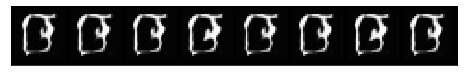

Epoch: 25 Iter: 2970 GLoss: 53.09984 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 25 Iter: 3025 GLoss: 53.10358 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 26 Iter: 3080 GLoss: 53.10372 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 26 Iter: 3135 GLoss: 53.09816 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 27 Iter: 3190 GLoss: 53.10856 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 27 Iter: 3245 GLoss: 53.11216 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 27 Iter: 3300 GLoss: 53.10357 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 28 Iter: 3355 GLoss: 53.10235 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 28 Iter: 3410 GLoss: 53.10982 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 29 Iter: 3465 GLoss: 53.10155 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 29 Iter: 3520 GLoss: 53.1114 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
====== Epoch 29 ======


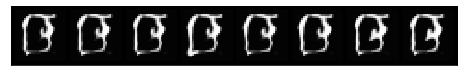

Epoch: 30 Iter: 3575 GLoss: 53.10439 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 30 Iter: 3630 GLoss: 53.11255 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 31 Iter: 3685 GLoss: 53.09876 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 31 Iter: 3740 GLoss: 53.11335 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 32 Iter: 3795 GLoss: 53.103 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 32 Iter: 3850 GLoss: 53.10783 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 33 Iter: 3905 GLoss: 53.09567 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 33 Iter: 3960 GLoss: 53.10282 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 34 Iter: 4015 GLoss: 53.11071 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 34 Iter: 4070 GLoss: 53.1115 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
Epoch: 34 Iter: 4125 GLoss: 53.11069 DLoss: 0.0 Avg_D_real 1.0 Avg_D_fake 0.0
====== Epoch 34 ======


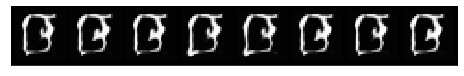

KeyboardInterrupt: 

In [16]:
print("Device in use: {}".format(CONFIG.DEVICE))

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for x, label in train_loader:
        x = x.to(CONFIG.DEVICE)
        
        with torch.no_grad():
            real = vqvae.encode(x)

        current_batch_dim = real.size(0)
        labels_real = torch.full((current_batch_dim,), 1.0, device=CONFIG.DEVICE)
        labels_fake = torch.full((current_batch_dim,), 0.0, device=CONFIG.DEVICE)

        D.zero_grad()
        G.zero_grad()
        
        ############################
        ### Update Discriminator ###
        ############################
        
        noise = torch.randn(current_batch_dim, CONFIG.noise_dim, 1, 1, device=CONFIG.DEVICE)
        fake = G(noise=noise)

        labels_D_real = D(real)
        d_loss_real = F.binary_cross_entropy(labels_D_real, labels_real)

        labels_D_fake = D(fake.detach())
        d_loss_fake = F.binary_cross_entropy(labels_D_fake, labels_fake)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        avg_label_D_real = labels_D_real.mean().item()
        avg_label_D_fake = labels_D_fake.mean().item()

        ############################
        ##### Update Generator #####
        ############################

        labels_D_fake = D(fake)

        g_loss = F.binary_cross_entropy(labels_D_fake, labels_real)
        g_loss.backward()
        optimizer_G.step()

        iteration += 1

        if iteration % 55 == 0:
            print("Epoch: {} Iter: {} GLoss: {} DLoss: {} Avg_D_real {} Avg_D_fake {}".format(
                epoch, 
                iteration, 
                round(g_loss.item(), 5), 
                round(d_loss.item(), 5), 
                round(avg_label_D_real, 5), 
                round(avg_label_D_fake, 5)
            ))
    
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_img = vqvae.q_decode(fake[:8, :, :, :])
        img_grid = make_grid(fake_img.detach().cpu())
        print("====== Epoch {} ======".format(epoch))
        show(img_grid)
        print("======================")

In [12]:
def compute_norm_weights(log_w):
    log_n = torch.log(torch.tensor(float(log_w.shape[0])))
    log_z_est = torch.logsumexp(log_w - log_n, dim=0)
    log_w_tilde = log_w - log_z_est - log_n

    w_tilde = torch.exp(log_w_tilde)

    return w_tilde

def multinomial_bgan_loss(D, fake_logits, reals, n_samples=8):
    batch_size = reals.size(0)
    n_channels = fake_logits.size(1)
    spatial_dims = fake_logits.shape[2:]

    fake_p = torch.softmax(fake_logits, dim=1).view(batch_size, n_channels, -1).transpose(1, 2)
    fake_p = fake_p.repeat(n_samples, 1, 1).view(-1, n_channels)

    samples = torch.multinomial(fake_p, num_samples=1)
    samples = samples.view(n_samples, batch_size, *spatial_dims)

    samples_one_hot = F.one_hot(samples, num_classes=n_channels).type(torch.float)
    samples_one_hot = samples_one_hot.permute(0, 1, 4, 2, 3)

    real_out = D(reals)
    fake_out = D(samples_one_hot.view(-1, *samples_one_hot.shape[2:]))

    log_w = fake_out.view(n_samples, batch_size)
    log_g = -(samples_one_hot * (
        fake_logits - torch.logsumexp(fake_logits, dim=1, keepdim=True)
    ).unsqueeze(0)).mean(dim=(2, 3, 4))

    w_tilde = compute_norm_weights(log_w).detach()

    d_loss = F.binary_cross_entropy_with_logits(real_out, torch.ones_like(real_out)) + \
             F.binary_cross_entropy_with_logits(fake_out, torch.zeros_like(fake_out))
    g_loss = (w_tilde * log_g).sum(0).mean()

    p_fake = (fake_out < 0).type(torch.float).mean().detach()
    p_real = (real_out > 0).type(torch.float).mean().detach()

    return d_loss, g_loss, p_fake, p_real

Device in use: cuda
Epoch: 0 Iter: 25 GLoss: 0.1076 DLoss: 1.00915
Epoch: 0 Iter: 50 GLoss: 0.10751 DLoss: 1.00655
Epoch: 0 Iter: 75 GLoss: 0.10748 DLoss: 1.0065
Epoch: 0 Iter: 100 GLoss: 0.10748 DLoss: 1.00648
Epoch: 1 Iter: 125 GLoss: 0.10746 DLoss: 1.00647
Epoch: 1 Iter: 150 GLoss: 0.10747 DLoss: 1.00646
Epoch: 1 Iter: 175 GLoss: 0.10748 DLoss: 1.00645
Epoch: 1 Iter: 200 GLoss: 0.10747 DLoss: 1.00645
Epoch: 1 Iter: 225 GLoss: 0.10748 DLoss: 1.00644
Epoch: 2 Iter: 250 GLoss: 0.10745 DLoss: 1.00644
Epoch: 2 Iter: 275 GLoss: 0.10745 DLoss: 1.00644
Epoch: 2 Iter: 300 GLoss: 0.10742 DLoss: 1.00643
Epoch: 2 Iter: 325 GLoss: 0.10745 DLoss: 1.00643
Epoch: 2 Iter: 350 GLoss: 0.10743 DLoss: 1.00643
Epoch: 3 Iter: 375 GLoss: 0.10744 DLoss: 1.00643
Epoch: 3 Iter: 400 GLoss: 0.10743 DLoss: 1.00642
Epoch: 3 Iter: 425 GLoss: 0.10743 DLoss: 1.00642
Epoch: 3 Iter: 450 GLoss: 0.10745 DLoss: 1.00642
Epoch: 4 Iter: 475 GLoss: 0.10743 DLoss: 1.00642
Epoch: 4 Iter: 500 GLoss: 0.10742 DLoss: 1.00642
Epoch

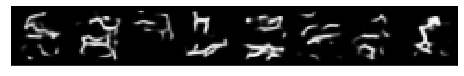

Epoch: 5 Iter: 600 GLoss: 0.10742 DLoss: 1.00642
Epoch: 5 Iter: 625 GLoss: 0.10744 DLoss: 1.00644
Epoch: 5 Iter: 650 GLoss: 0.10745 DLoss: 1.00642
Epoch: 5 Iter: 675 GLoss: 0.10743 DLoss: 1.00645
Epoch: 5 Iter: 700 GLoss: 0.10743 DLoss: 1.00642
Epoch: 6 Iter: 725 GLoss: 0.10744 DLoss: 1.00642
Epoch: 6 Iter: 750 GLoss: 0.10742 DLoss: 1.00642
Epoch: 6 Iter: 775 GLoss: 0.10746 DLoss: 1.00642
Epoch: 6 Iter: 800 GLoss: 0.10744 DLoss: 1.00642
Epoch: 6 Iter: 825 GLoss: 0.10743 DLoss: 1.00642
Epoch: 7 Iter: 850 GLoss: 0.10743 DLoss: 1.00642
Epoch: 7 Iter: 875 GLoss: 0.10742 DLoss: 1.01504
Epoch: 7 Iter: 900 GLoss: 0.10744 DLoss: 1.00654
Epoch: 7 Iter: 925 GLoss: 0.10744 DLoss: 1.00649
Epoch: 8 Iter: 950 GLoss: 0.10743 DLoss: 1.00655
Epoch: 8 Iter: 975 GLoss: 0.10743 DLoss: 1.00643
Epoch: 8 Iter: 1000 GLoss: 0.10743 DLoss: 1.00642
Epoch: 8 Iter: 1025 GLoss: 0.10744 DLoss: 1.00642
Epoch: 8 Iter: 1050 GLoss: 0.10743 DLoss: 1.00642
Epoch: 9 Iter: 1075 GLoss: 0.10744 DLoss: 1.00642
Epoch: 9 Iter: 1

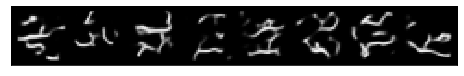

Epoch: 10 Iter: 1200 GLoss: 0.10742 DLoss: 1.00641
Epoch: 10 Iter: 1225 GLoss: 0.10741 DLoss: 1.00641
Epoch: 10 Iter: 1250 GLoss: 0.10742 DLoss: 1.00641
Epoch: 10 Iter: 1275 GLoss: 0.10741 DLoss: 1.00646
Epoch: 11 Iter: 1300 GLoss: 0.10742 DLoss: 1.00641
Epoch: 11 Iter: 1325 GLoss: 0.10743 DLoss: 1.00641
Epoch: 11 Iter: 1350 GLoss: 0.10743 DLoss: 1.00642
Epoch: 11 Iter: 1375 GLoss: 0.10741 DLoss: 1.00641
Epoch: 11 Iter: 1400 GLoss: 0.10743 DLoss: 1.00641
Epoch: 12 Iter: 1425 GLoss: 0.10744 DLoss: 1.00642
Epoch: 12 Iter: 1450 GLoss: 0.10742 DLoss: 1.00641
Epoch: 12 Iter: 1475 GLoss: 0.10743 DLoss: 1.00641
Epoch: 12 Iter: 1500 GLoss: 0.10742 DLoss: 1.00641
Epoch: 12 Iter: 1525 GLoss: 0.10743 DLoss: 1.00641
Epoch: 13 Iter: 1550 GLoss: 0.10743 DLoss: 1.00641
Epoch: 13 Iter: 1575 GLoss: 0.10741 DLoss: 1.00642
Epoch: 13 Iter: 1600 GLoss: 0.10743 DLoss: 1.00641
Epoch: 13 Iter: 1625 GLoss: 0.10741 DLoss: 1.00641
Epoch: 13 Iter: 1650 GLoss: 0.10742 DLoss: 1.00641
Epoch: 14 Iter: 1675 GLoss: 0.1

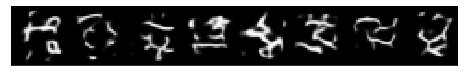

Epoch: 15 Iter: 1775 GLoss: 0.10741 DLoss: 1.00641
Epoch: 15 Iter: 1800 GLoss: 0.10743 DLoss: 1.00641
Epoch: 15 Iter: 1825 GLoss: 0.10743 DLoss: 1.00641
Epoch: 15 Iter: 1850 GLoss: 0.10742 DLoss: 1.00641
Epoch: 15 Iter: 1875 GLoss: 0.10743 DLoss: 1.00641
Epoch: 16 Iter: 1900 GLoss: 0.10742 DLoss: 1.00641
Epoch: 16 Iter: 1925 GLoss: 0.10741 DLoss: 1.00641
Epoch: 16 Iter: 1950 GLoss: 0.10743 DLoss: 1.00641
Epoch: 16 Iter: 1975 GLoss: 0.10742 DLoss: 1.00641
Epoch: 16 Iter: 2000 GLoss: 0.10742 DLoss: 1.00641
Epoch: 17 Iter: 2025 GLoss: 0.10742 DLoss: 1.00641
Epoch: 17 Iter: 2050 GLoss: 0.10743 DLoss: 1.00641
Epoch: 17 Iter: 2075 GLoss: 0.1074 DLoss: 1.00641
Epoch: 17 Iter: 2100 GLoss: 0.10742 DLoss: 1.00641
Epoch: 18 Iter: 2125 GLoss: 0.10741 DLoss: 1.00641
Epoch: 18 Iter: 2150 GLoss: 0.10741 DLoss: 1.00641
Epoch: 18 Iter: 2175 GLoss: 0.10743 DLoss: 1.00641
Epoch: 18 Iter: 2200 GLoss: 0.10743 DLoss: 1.00641
Epoch: 18 Iter: 2225 GLoss: 0.10742 DLoss: 1.00643
Epoch: 19 Iter: 2250 GLoss: 0.10

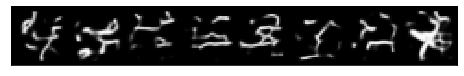

Epoch: 20 Iter: 2375 GLoss: 0.10741 DLoss: 1.00641
Epoch: 20 Iter: 2400 GLoss: 0.1074 DLoss: 1.00641
Epoch: 20 Iter: 2425 GLoss: 0.10743 DLoss: 1.00646
Epoch: 20 Iter: 2450 GLoss: 0.10742 DLoss: 1.00641
Epoch: 20 Iter: 2475 GLoss: 0.10744 DLoss: 1.00642
Epoch: 21 Iter: 2500 GLoss: 0.10742 DLoss: 1.00641
Epoch: 21 Iter: 2525 GLoss: 0.1074 DLoss: 1.00641
Epoch: 21 Iter: 2550 GLoss: 0.10744 DLoss: 1.00641
Epoch: 21 Iter: 2575 GLoss: 0.1074 DLoss: 1.00641
Epoch: 22 Iter: 2600 GLoss: 0.1074 DLoss: 1.00641
Epoch: 22 Iter: 2625 GLoss: 0.10742 DLoss: 1.00641
Epoch: 22 Iter: 2650 GLoss: 0.10743 DLoss: 1.00641
Epoch: 22 Iter: 2675 GLoss: 0.10743 DLoss: 1.00642
Epoch: 22 Iter: 2700 GLoss: 0.10741 DLoss: 1.00641
Epoch: 23 Iter: 2725 GLoss: 0.10742 DLoss: 1.00641
Epoch: 23 Iter: 2750 GLoss: 0.10742 DLoss: 1.00641
Epoch: 23 Iter: 2775 GLoss: 0.10743 DLoss: 1.00641
Epoch: 23 Iter: 2800 GLoss: 0.10742 DLoss: 1.00641
Epoch: 23 Iter: 2825 GLoss: 0.10741 DLoss: 1.00641
Epoch: 24 Iter: 2850 GLoss: 0.10742

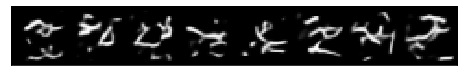

Epoch: 25 Iter: 2975 GLoss: 0.1074 DLoss: 1.00641
Epoch: 25 Iter: 3000 GLoss: 0.10742 DLoss: 1.00641
Epoch: 25 Iter: 3025 GLoss: 0.10745 DLoss: 1.00641
Epoch: 25 Iter: 3050 GLoss: 0.1074 DLoss: 1.00641
Epoch: 26 Iter: 3075 GLoss: 0.10742 DLoss: 1.00641
Epoch: 26 Iter: 3100 GLoss: 0.10742 DLoss: 1.00641
Epoch: 26 Iter: 3125 GLoss: 0.10742 DLoss: 1.00641
Epoch: 26 Iter: 3150 GLoss: 0.10743 DLoss: 1.00641
Epoch: 26 Iter: 3175 GLoss: 0.10743 DLoss: 1.00641
Epoch: 27 Iter: 3200 GLoss: 0.10742 DLoss: 1.00641
Epoch: 27 Iter: 3225 GLoss: 0.10745 DLoss: 1.00641
Epoch: 27 Iter: 3250 GLoss: 0.10741 DLoss: 1.00641
Epoch: 27 Iter: 3275 GLoss: 0.10743 DLoss: 1.00641
Epoch: 27 Iter: 3300 GLoss: 0.10741 DLoss: 1.00641
Epoch: 28 Iter: 3325 GLoss: 0.10742 DLoss: 1.00641
Epoch: 28 Iter: 3350 GLoss: 0.10742 DLoss: 1.00641
Epoch: 28 Iter: 3375 GLoss: 0.10743 DLoss: 1.00641
Epoch: 28 Iter: 3400 GLoss: 0.10742 DLoss: 1.00641
Epoch: 29 Iter: 3425 GLoss: 0.10743 DLoss: 1.00641
Epoch: 29 Iter: 3450 GLoss: 0.107

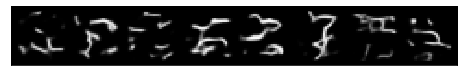

Epoch: 30 Iter: 3550 GLoss: 0.10743 DLoss: 1.00642
Epoch: 30 Iter: 3575 GLoss: 0.1074 DLoss: 1.00641
Epoch: 30 Iter: 3600 GLoss: 0.10742 DLoss: 1.00641
Epoch: 30 Iter: 3625 GLoss: 0.10743 DLoss: 1.00641
Epoch: 30 Iter: 3650 GLoss: 0.10743 DLoss: 1.00641
Epoch: 31 Iter: 3675 GLoss: 0.10743 DLoss: 1.00641
Epoch: 31 Iter: 3700 GLoss: 0.1074 DLoss: 1.00641
Epoch: 31 Iter: 3725 GLoss: 0.10743 DLoss: 1.00641
Epoch: 31 Iter: 3750 GLoss: 0.1074 DLoss: 1.00641
Epoch: 31 Iter: 3775 GLoss: 0.10742 DLoss: 1.00641
Epoch: 32 Iter: 3800 GLoss: 0.10741 DLoss: 1.00641
Epoch: 32 Iter: 3825 GLoss: 0.10741 DLoss: 1.00641
Epoch: 32 Iter: 3850 GLoss: 0.10743 DLoss: 1.00641
Epoch: 32 Iter: 3875 GLoss: 0.10742 DLoss: 1.00641
Epoch: 33 Iter: 3900 GLoss: 0.10743 DLoss: 1.00641
Epoch: 33 Iter: 3925 GLoss: 0.10741 DLoss: 1.00641
Epoch: 33 Iter: 3950 GLoss: 0.10742 DLoss: 1.00641
Epoch: 33 Iter: 3975 GLoss: 0.10741 DLoss: 1.00641
Epoch: 33 Iter: 4000 GLoss: 0.10744 DLoss: 1.00641
Epoch: 34 Iter: 4025 GLoss: 0.1074

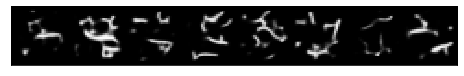

Epoch: 35 Iter: 4150 GLoss: 0.10742 DLoss: 1.00641
Epoch: 35 Iter: 4175 GLoss: 0.10743 DLoss: 1.00641
Epoch: 35 Iter: 4200 GLoss: 0.10745 DLoss: 1.00641
Epoch: 35 Iter: 4225 GLoss: 0.10743 DLoss: 1.00641
Epoch: 36 Iter: 4250 GLoss: 0.10741 DLoss: 1.00641
Epoch: 36 Iter: 4275 GLoss: 0.10742 DLoss: 1.00641
Epoch: 36 Iter: 4300 GLoss: 0.10742 DLoss: 1.00641
Epoch: 36 Iter: 4325 GLoss: 0.10742 DLoss: 1.00641
Epoch: 36 Iter: 4350 GLoss: 0.10742 DLoss: 1.00641
Epoch: 37 Iter: 4375 GLoss: 0.10742 DLoss: 1.00641
Epoch: 37 Iter: 4400 GLoss: 0.10742 DLoss: 1.00641
Epoch: 37 Iter: 4425 GLoss: 0.10741 DLoss: 1.00641
Epoch: 37 Iter: 4450 GLoss: 0.10741 DLoss: 1.00643
Epoch: 37 Iter: 4475 GLoss: 0.10741 DLoss: 1.00642
Epoch: 38 Iter: 4500 GLoss: 0.10742 DLoss: 1.00644
Epoch: 38 Iter: 4525 GLoss: 0.10742 DLoss: 1.00645
Epoch: 38 Iter: 4550 GLoss: 0.10742 DLoss: 1.00646
Epoch: 38 Iter: 4575 GLoss: 0.10744 DLoss: 1.00641
Epoch: 38 Iter: 4600 GLoss: 0.10741 DLoss: 1.00641
Epoch: 39 Iter: 4625 GLoss: 0.1

KeyboardInterrupt: 

In [13]:
print("Device in use: {}".format(CONFIG.DEVICE))

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for x, label in train_loader:
        x = x.to(CONFIG.DEVICE)
        
        with torch.no_grad():
            real = dvae.q_encode(x, hard=True)

        current_batch_dim = real.size(0)
        
        #D.zero_grad()
        #G.zero_grad()
        
        noise = torch.randn(current_batch_dim, CONFIG.noise_dim, 1, 1, device=CONFIG.DEVICE)
        fake = G(noise=noise)
        
        d_loss, g_loss, p_fake, p_real = multinomial_bgan_loss(
            D=D,
            fake_logits=fake,
            reals=real,
            n_samples=20)
        
        optimizer_D.zero_grad()
        optimizer_G.zero_grad()

        torch.autograd.backward([d_loss, g_loss])

        optimizer_D.step()
        optimizer_G.step()
        
        iteration += 1

        if iteration % 25 == 0:
            print("Epoch: {} Iter: {} GLoss: {} DLoss: {}".format(
                epoch, 
                iteration, 
                round(g_loss.item(), 5), 
                round(d_loss.item(), 5)
            ))
    
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_img = dvae.q_decode(fake[:8, :, :, :], hard=True)
        img_grid = make_grid(fake_img.detach().cpu())
        print("====== Epoch {} ======".format(epoch))
        show(img_grid)
        print("======================")

Device in use: cuda
Epoch: 0 Iter: 55 GLoss: 1.05022 DLoss: 0.44164 Avg_D_real 0.70655 Avg_D_fake 0.40301 Temperature 9.89408
Epoch: 0 Iter: 110 GLoss: 1.83389 DLoss: 0.20154 Avg_D_real 0.83065 Avg_D_fake 0.18881 Temperature 9.78417
Epoch: 1 Iter: 165 GLoss: 2.49585 DLoss: 0.08786 Avg_D_real 0.91976 Avg_D_fake 0.08718 Temperature 9.67426
Epoch: 1 Iter: 220 GLoss: 2.71341 DLoss: 0.09403 Avg_D_real 0.92536 Avg_D_fake 0.09996 Temperature 9.56435
Epoch: 2 Iter: 275 GLoss: 3.17596 DLoss: 0.04698 Avg_D_real 0.95588 Avg_D_fake 0.04684 Temperature 9.45444
Epoch: 2 Iter: 330 GLoss: 3.61226 DLoss: 0.03056 Avg_D_real 0.96891 Avg_D_fake 0.02896 Temperature 9.34452
Epoch: 3 Iter: 385 GLoss: 3.80721 DLoss: 0.03644 Avg_D_real 0.95535 Avg_D_fake 0.02438 Temperature 9.23461
Epoch: 3 Iter: 440 GLoss: 4.10701 DLoss: 0.01929 Avg_D_real 0.9792 Avg_D_fake 0.01726 Temperature 9.1247
Epoch: 4 Iter: 495 GLoss: 4.25331 DLoss: 0.01501 Avg_D_real 0.985 Avg_D_fake 0.01477 Temperature 9.01479
Epoch: 4 Iter: 550 GLo

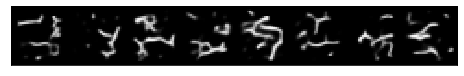

Epoch: 5 Iter: 605 GLoss: 4.51532 DLoss: 0.01176 Avg_D_real 0.98857 Avg_D_fake 0.01191 Temperature 8.79496


KeyboardInterrupt: 

In [13]:
print("Device in use: {}".format(CONFIG.DEVICE))

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for x, label in train_loader:
        x = x.to(CONFIG.DEVICE)
        
        with torch.no_grad():
            real = dvae.sm_encode(x)

        current_batch_dim = real.size(0)
        labels_real = torch.full((current_batch_dim,), 1.0, device=CONFIG.DEVICE)
        labels_fake = torch.full((current_batch_dim,), 0.0, device=CONFIG.DEVICE)

        D.zero_grad()
        G.zero_grad()
        
        ############################
        ### Update Discriminator ###
        ############################
        
        noise = torch.randn(current_batch_dim, CONFIG.noise_dim, 1, 1, device=CONFIG.DEVICE)
        fake = G(noise=noise)

        labels_D_real = D(real)
        d_loss_real = F.binary_cross_entropy(labels_D_real, labels_real)

        labels_D_fake = D(fake.detach())
        d_loss_fake = F.binary_cross_entropy(labels_D_fake, labels_fake)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        avg_label_D_real = labels_D_real.mean().item()
        avg_label_D_fake = labels_D_fake.mean().item()

        ############################
        ##### Update Generator #####
        ############################

        labels_D_fake = D(fake)

        g_loss = F.binary_cross_entropy(labels_D_fake, labels_real)
        g_loss.backward()
        optimizer_G.step()

        iteration += 1

        if iteration % 55 == 0:
            print("Epoch: {} Iter: {} GLoss: {} DLoss: {} Avg_D_real {} Avg_D_fake {} Temperature {}".format(
                epoch, 
                iteration, 
                round(g_loss.item(), 5), 
                round(d_loss.item(), 5), 
                round(avg_label_D_real, 5), 
                round(avg_label_D_fake, 5),
                #round(temp, 5)
            ))
    
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_img = dvae.q_decode(fake[:8, :, :, :], hard=True)
        img_grid = make_grid(fake_img.detach().cpu())
        print("====== Epoch {} ======".format(epoch))
        show(img_grid)
        print("======================")

In [8]:
# https://github.com/Yangyangii/GAN-Tutorial/blob/master/CelebA/R1GAN.ipynb

def r1loss(inputs, label=None):
    # non-saturating loss with R1 regularization
    l = -1 if label else 1
    return F.softplus(l * inputs).mean()

R1_GAMMA = 10

In [21]:
print("Device in use: {}".format(CONFIG.DEVICE))

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for x, label in train_loader:
        x = x.to(CONFIG.DEVICE)
        with torch.no_grad():
            real = dvae.q_encode(x, hard=True)

        current_batch_dim = real.size(0)
        
        ############################
        ### Update Discriminator ###
        ############################
        G.zero_grad()

        # Real image
        real.requires_grad = True
        labels_D_real = D(real)

        R1_loss = r1loss(labels_D_real, True)

        grad_real = grad(outputs=labels_D_real.sum(), inputs=real, create_graph=True)[0].contiguous()
        grad_penalty = (grad_real.view(current_batch_dim, -1).norm(2, dim=1) ** 2).mean()
        grad_penalty = 0.5 * R1_GAMMA * grad_penalty

        D_real_loss = R1_loss + grad_penalty

        # Fake image
        noise = torch.randn(current_batch_dim, CONFIG.noise_dim, device=CONFIG.DEVICE)
        fake = G(noise, hard=True)

        labels_D_fake = D(fake.detach())
        D_fake_loss = r1loss(labels_D_fake, False)

        # Discriminator loss
        D_loss = D_real_loss + D_fake_loss

        D.zero_grad()
        D_loss.backward()
        optimizer_D.step()
        
        ############################
        ##### Update Generator #####
        ############################
        noise = torch.randn(current_batch_dim, CONFIG.noise_dim, device=CONFIG.DEVICE)
        fake = G(noise, hard=True)

        labels_D_fake = D(fake)
        G_loss = r1loss(labels_D_fake, True)

        G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        iteration += 1

        if iteration % 40 == 0:
            print("Epoch: {} Iter: {} GLoss: {} DLoss: {}".format(
                epoch, iteration, G_loss.item(), D_loss.item()))
    
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_img = dvae.q_decode(fake[:8, :, :, :], hard=True)
        img_grid = make_grid(fake_img.detach().cpu())
        print("====== Epoch {} ======".format(epoch))
        show(img_grid)
        print("======================")

Device in use: cpu
Epoch: 0 Iter: 1 GLoss: 0.6722345948219299 DLoss: 1.3876996040344238
Epoch: 0 Iter: 2 GLoss: 0.6769079566001892 DLoss: 1.3869105577468872
Epoch: 0 Iter: 3 GLoss: 0.6798290014266968 DLoss: 1.3869516849517822


KeyboardInterrupt: 

In [ ]:
# print("Device in use: {}".format(CONFIG.DEVICE))

# iteration = 0
# for epoch in range(CONFIG.NUM_EPOCHS):
#     for x, label in train_loader:
#         x = x.to(CONFIG.DEVICE)
#         with torch.no_grad():
#             real = dvae.q_encode(x, hard=True)

#         current_batch_dim = real.size(0)
#         labels_real = torch.full((current_batch_dim,), 1.0, device=CONFIG.DEVICE)
#         labels_fake = torch.full((current_batch_dim,), 0.0, device=CONFIG.DEVICE)

#         ############################
#         ### Update Discriminator ###
#         ############################
#         D.zero_grad()
#         noise = torch.randn(current_batch_dim, CONFIG.noise_dim, device=CONFIG.DEVICE)
#         fake = G(noise=noise, hard=True)

#         labels_D_real = D(real)
#         d_loss_real = F.binary_cross_entropy(labels_D_real, labels_real)

#         labels_D_fake = D(fake.detach())
#         d_loss_fake = F.binary_cross_entropy(labels_D_fake, labels_fake)

#         d_loss = (d_loss_real + d_loss_fake) / 2
#         d_loss.backward()
#         optimizer_D.step()

#         avg_label_D_real = labels_D_real.mean().item()
#         avg_label_D_fake = labels_D_fake.mean().item()

#         ############################
#         ##### Update Generator #####
#         ############################
#         G.zero_grad()

#         labels_D_fake = D(fake)

#         g_loss = F.binary_cross_entropy(labels_D_fake, labels_real)
#         g_loss.backward()
#         optimizer_G.step()

#         iteration += 1

#         if iteration % 40 == 0:
#             print("Epoch: {} Iter: {} GLoss: {} DLoss: {} Avg_D_real {} Avg_D_fake {}".format(
#                 epoch, iteration, g_loss.item(), d_loss.item(), avg_label_D_real, avg_label_D_fake))
    
#     if (epoch + 1) % 5 == 0:
#         with torch.no_grad():
#             fake_img = dvae.q_decode(fake[:8, :, :, :], hard=True)
#         img_grid = make_grid(fake_img.detach().cpu())
#         print("====== Epoch {} ======".format(epoch))
#         show(img_grid)
#         print("======================")